In [1]:
from implicit_learning.trainer import PoissonTrainer 
from implicit_learning.model import  EoREN
from implicit_learning.dataset import PoissonEqn
from implicit_learning.utils import *
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from torch.utils.data import DataLoader 

import torch
import matplotlib.pyplot as plt 


In [2]:
def construct_dataloader(config):
    sidelength = config['sidelength']
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])

    train = PoissonEqn(config, transform=transform)
    valid = PoissonEqn(config, transform=transform)
    test  = PoissonEqn(config, transform=transform)
    
    train_dataloader =  DataLoader(train, batch_size=config.get("batch_size"), shuffle=True, pin_memory=True)
    valid_datalodaer =  DataLoader(valid, batch_size=config.get("batch_size"), shuffle=True, pin_memory=True)
    test_dataloader =   DataLoader(test, batch_size=config.get("batch_size"), shuffle=True, pin_memory=True)

    return train_dataloader, valid_datalodaer, test_dataloader


class CustomizeTrainer(PoissonTrainer):
    def __init__(self, model, train_dataloader, valid_dataloader, test_dataloader, config):
        super().__init__(model, train_dataloader, valid_dataloader, test_dataloader, config)
        self.lr_siren = config.get("lr_siren")
        self.lr_offset = config.get("lr_offset")
        self.optimizer1 = torch.optim.Adam(self.model.siren.parameters(), lr=self.lr_siren)
        self.optimizer2 = torch.optim.Adam(self.model.offset.parameters(), lr=self.lr_offset)
        self.sidelength = config.get("sidelength")


    def compute_loss(self, h, g, coords, alpha=0.3):
        edge_loss = self.gradients_mse(g, coords, self.gt['grads'])
        offset_loss = ((h - self.gt['pixels'])**2).mean()
         
        return edge_loss, offset_loss

    def train(self):
        for epoch in range(self.epochs):

            self.optimizer1.zero_grad() 
            self.optimizer2.zero_grad()

            inputs = self.model_input
            h, g, coords =self.model.forward(inputs)
            
            edge, offset = self.compute_loss(h, g, coords, alpha=1) 

            if epoch % config.get("print_epoch") == 0:
                print("Epoch %4d"%(epoch), f" : Loss : ",  edge.item(), offset.item() )
                img_grad = gradient(g, coords)
                self.plot(h, self.gt['pixels'], img_grad, self.gt)
            
            edge.backward()
            offset.backward()
            self.optimizer1.step()
            self.optimizer2.step()

    def plot(self, model_output, original, img_grad, gt):
        fig, axes = plt.subplots(1, 4, figsize=(8, 3))
        axes[0].imshow(model_output.cpu().view(self.sidelength,self.sidelength).detach().numpy(), vmin=0.5-1, vmax=0.5+1)
        axes[1].imshow(original.cpu().view(self.sidelength,self.sidelength).detach().numpy(), vmin=0.5-1, vmax=0.5+1)
        axes[2].imshow(img_grad.cpu().norm(dim=-1).view(self.sidelength,self.sidelength).detach().numpy(), vmin=0.5-1, vmax=0.5+1)
        axes[3].imshow(gt['grads'].cpu().norm(dim=-1).view(self.sidelength,self.sidelength).detach().numpy(), vmin=0.5-1, vmax=0.5+1)
        plt.show()

Epoch    0  : Loss :  136.1662139892578 0.1411275714635849


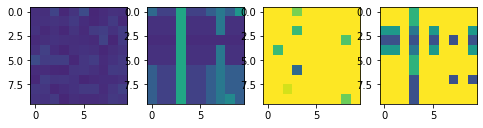

Epoch  100  : Loss :  0.2148398905992508 0.07535827904939651


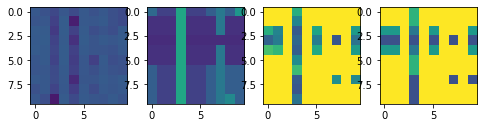

Epoch  200  : Loss :  2.9643229026987683e-06 0.07321815192699432


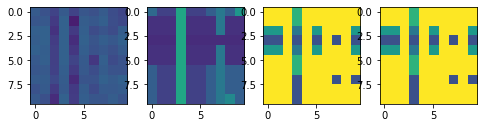

Epoch  300  : Loss :  1.976687702409663e-10 0.0732179656624794


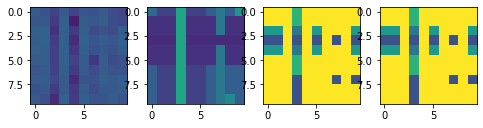

Epoch  400  : Loss :  6.016939030351054e-11 0.07321797311306


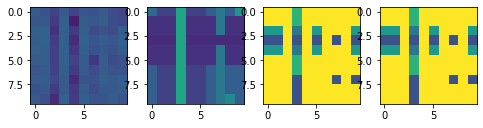

Epoch  500  : Loss :  1.3993897707287317e-10 0.0732179656624794


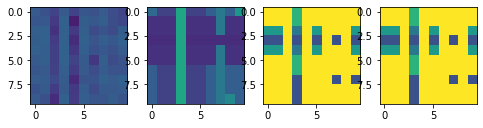

Epoch  600  : Loss :  2.5884516752228137e-09 0.07321797311306


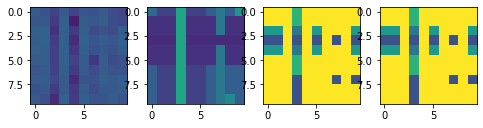

Epoch  700  : Loss :  0.007090716157108545 0.08530746400356293


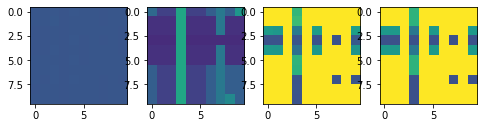

Epoch  800  : Loss :  2.4459356495754037e-07 0.07878715544939041


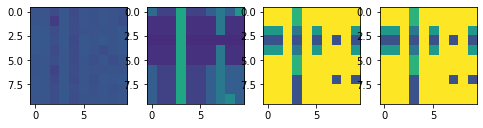

Epoch  900  : Loss :  2.8496505155573004e-09 0.0764244869351387


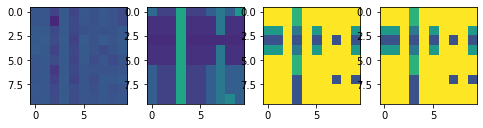

In [3]:

config = {
    "model":{
        "in_features":2,
        "hidden_features":256,
        "hidden_layers":5,
        "out_features":1
    },
    "sidelength":10,
    "epochs":1000,
    "lr_siren":0.0001,
    "lr_offset":0.1,
    "batch_size":1,
    "data-path":"../../data/small.png",
    "print_epoch":100
}

model = EoREN(**config['model'])
model.siren.cuda()
model.offset.cuda()
trainer = CustomizeTrainer(model, *construct_dataloader(config), config)
trainer.train()


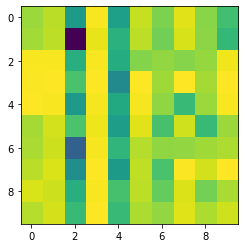

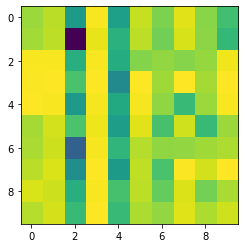

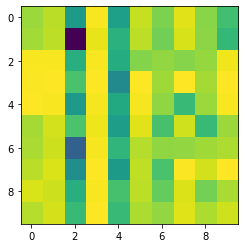

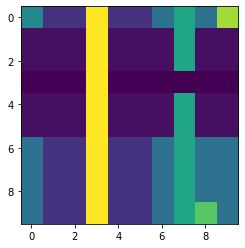

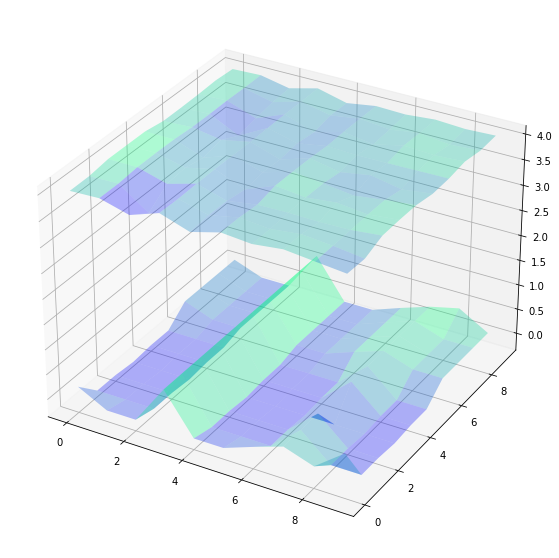

In [6]:
model_input = trainer.model_input 
image = trainer.model.forward(model_input)
for b in np.linspace(-1,1,3):
    temp = image[0] + b 
    temp = temp.reshape(trainer.sidelength, trainer.sidelength).detach().cpu().numpy()
    plt.figure()
    plt.imshow(temp)

truth  = trainer.gt['pixels'].detach().cpu().numpy().reshape(10,10)
plt.figure()
plt.imshow(truth)

temp = temp - temp.mean() +4
truth = truth - truth.mean()


from mpl_toolkits.mplot3d import Axes3D
x, y = np.meshgrid(range(10), range(10))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d', )


ax.plot_surface(x,y, truth, rstride=1, cstride=1,
                cmap='winter', edgecolor='none', alpha=0.3)

ax.plot_surface(x,y, temp, rstride=1, cstride=1,
                cmap='winter', edgecolor='none', alpha=0.3)



In [5]:
trainer.gt['grads'].size()

torch.Size([1, 100, 2])